In [37]:
import warnings
warnings.filterwarnings(action="ignore")

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
%matplotlib inline
import requests
import csv

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout

from tensorflow import keras


import plotly.express as px

In [38]:
# CSV_URL_LISTING = 'https://www.alphavantage.co/query?function=LISTING_STATUS&apikey=WOVNUEXRHX1P3Q98'


# with requests.Session() as s:
#     download = s.get(CSV_URL_LISTING)
#     decoded_content = download.content.decode('utf-8')
#     cr = csv.reader(decoded_content.splitlines(), delimiter=',')
#     my_list = list(cr)

# listing = pd.DataFrame(my_list, columns=("symbol", "name", "exchange", "assetType", "ipoDate", "delistingDate", "status"))
# listing.drop(listing.index[0], inplace=True)
# listing

In [39]:
listing = pd.read_csv("../z.TFM/listing_status.csv")
listing

,symbol,name,exchange,assetType,ipoDate,delistingDate,status
0,A,Agilent Technologies Inc,NYSE,Stock,1999-11-18,NaN,Active
1,AA,Alcoa Corp,NYSE,Stock,2016-10-18,NaN,Active
2,AAA,AAF First Priority CLO Bond ETF,NYSE ARCA,ETF,2020-09-09,NaN,Active
3,AAAU,Goldman Sachs Physical Gold ETF,NYSE ARCA,ETF,2018-08-15,NaN,Active
4,AAC,Ares Acquisition Corporation - Class A,NYSE,Stock,2021-03-25,NaN,Active
...,...,...,...,...,...,...,...
12240,ZYME,Zymeworks Inc,NYSE,Stock,2017-04-28,NaN,Active
12241,ZYNE,Zynerba Pharmaceuticals Inc,NASDAQ,Stock,2015-08-05,NaN,Active
12242,ZYXI,Zynex Inc,NASDAQ,Stock,2012-07-23,NaN,Active
12243,ZZK,NaN,NYSE ARCA,Stock,2020-07-22,NaN,Active


In [40]:
#symbol = sacarlo de listing
#timeframe = [5,15,30,60]
#model = [ARIMA, LSTM, NAIVE]


def update_graph(symbol, timeframe, model):
    df_filtered = listing[listing['symbol']==symbol]
    

    year = [1,2]
    month = [1,2,3,4,5,6,7,8,9,10,11,12]
    real = pd.DataFrame()

    for y in range(2):
        for m in range(12):
            URL= 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol='+symbol+'&interval='+str(timeframe)+'min&slice=year'+str(year[y])+'month'+str(month[m])+'&apikey=UHV76ERHZOBH4LU8'

            with requests.Session() as s:
                download = s.get(URL)
                decoded_content = download.content.decode('utf-8')
                cr = csv.reader(decoded_content.splitlines(), delimiter=',')
                my_list = list(cr)

                aux = pd.DataFrame(my_list, columns=("time", "open", "high", "low", "close", "volume"))
                aux.drop(aux.index[0], inplace=True)
                real = real.append(aux, ignore_index=True)

    real.sort_values("time", ascending=True, inplace=True)
    real["time"] = pd.to_datetime(real["time"])
    real["close"] = pd.to_numeric(real["close"])
    real = real[["time", "close"]]
    real.reset_index(drop=True, inplace=True)
    real = real.dropna().reset_index()

    # split train y test
    TEST_SIZE = 0.2

    train = real[:(int(len(real)*(1-TEST_SIZE)))]
    test = real[(int(len(real)*(1-TEST_SIZE))):]
    
    if model == 'ARIMA':
        # Applying log
        real_log = np.log(real["close"])
        train_log = np.log(train["close"])
        test_log = np.log(test["close"])

        # Training model
        p=1
        d=1
        q=1
        model = ARIMA(train_log, order=(p, d, q))
        fitted_model = model.fit()
        fitted_train = fitted_model.fittedvalues

        # Get Test Set Predictions
        predict_test = fitted_model.predict(test_log.index[0], test_log.index[len(test_log)-1])

         # Reverting from differencing
        fitted_train = fitted_train + train_log.shift(periods=d)
        predict_test = predict_test + test_log.shift(periods=d)

        # Get normal scale
        fitted_train = np.exp(fitted_train)
        predict_test = np.exp(predict_test)

        # Get R2 from Test Set
        real_values = test['close'][d:]
        pred_values = predict_test[d:]
        r2 = r2_score(real_values, pred_values)
        
        
        # Get predictions from whole set
        predictions = fitted_model.predict(real[d:].index[0], real[d:].index[len(real[d:])-1])

        # Reverting from differencing
        predictions = predictions +  real_log[d:].shift(periods=d)

        # Get normal scale
        predictions = np.exp(predictions)
        

        
        #To calculate naive model R2:
        # Training model
        fitted_train_naive = train.shift(periods=1)

        # Get Test Set Predictions
        predict_test_naive = test.shift(periods=1)

        # Get RMSE from Test Set
        real_values_naive = test['close'][1:]
        pred_values_naive = predict_test_naive['close'][1:]
       

        
        R2_test = r2
        R2_test = np.round(R2_test,3) 
        R2_naive = r2_score(real_values_naive, pred_values_naive)
        R2_naive = np.round(R2_naive, 3)
    

        
    elif model == 'LSTM':
        train = pd.DataFrame(train['close'])
        test = pd.DataFrame(test['close'])

        # train
        sc = MinMaxScaler(feature_range=(0,1))
        scaled_train = sc.fit_transform(train)

        time_step = 20
        m = len(scaled_train)
        X_train = []
        Y_train = []


        for i in range(time_step,m):
            # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
            X_train.append(scaled_train[i-time_step:i,0])

            # Y: el siguiente dato
            Y_train.append(scaled_train[i,0])

        X_train, Y_train = np.array(X_train), np.array(Y_train)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


        # test
        scaled_test = sc.transform(test)

        X_test = []
        Y_test = []
        m = len(scaled_test)

        for i in range(time_step, m):
            X_test.append(scaled_test[i-time_step:i,0])
            Y_test.append(scaled_test[i,0])

        X_test, Y_test = np.array(X_test), np.array(Y_test)

        X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

        # model structure
        dim_entrada = (X_train.shape[1],1)
        dim_salida = 1
        na = 8


        model = Sequential()
        model.add(LSTM(na, input_shape=dim_entrada)) 
        model.add(Dropout(rate=0.2))
        model.add(Dense(dim_salida))
        model.compile(loss='mean_squared_error',
                      optimizer="adam",
                      metrics=['mse'])

        # model train
        epochs = 25
        batch_size = 32
        model_trained = model.fit(X_train, Y_train, epochs=epochs,
                                batch_size=batch_size, verbose=2)

         # test and train forescast
        test_close= test.values
        total= pd.concat([train['close'], test['close']],axis=0) # Concating train and test and then will take last 20 train point

        test_input = total[len(total)-len(test)-20:].values

        test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
        scaled_test = sc.transform(test_input)

        X_test= []

        m = len(scaled_test)

        for i in range(time_step,m):
            X_test.append(scaled_test[i-time_step:i,0]) #creating input for lstm prediction


        X_test= np.array(X_test)
        X_test= np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))


        predicted_value_entrenamiento= model.predict(X_train)
        predicted_value_entrenamiento = sc.inverse_transform(predicted_value_entrenamiento)

        predicted_value= model.predict(X_test)
        predicted_value = sc.inverse_transform(predicted_value)


        pred_train = pd.DataFrame(predicted_value_entrenamiento)
        pred_test = pd.DataFrame(predicted_value)
        predictions = pd.concat([pred_train, pred_test], axis=0, ignore_index=True)
        real = real[time_step:].reset_index()
        
        R2_test= r2_score(test[:], predicted_value)
        R2_test = np.round(R2_test,3)              
        R2_naive = r2_score(test[1:], test[:-1])
        R2_naive = np.round(R2_naive, 3)
        
    
    real['pred_close'] = predictions

    fig = px.line(real, x="time", y=["close", "pred_close"], title = 'stock/etf: '+ symbol + ';   R2 test: '+str(R2_test)+';    R2 naive: '+str(R2_naive))
    

    return fig

Epoch 1/25
199/199 - 6s - loss: 0.0299 - mse: 0.0299 - 6s/epoch - 32ms/step
Epoch 2/25
199/199 - 1s - loss: 0.0064 - mse: 0.0064 - 1s/epoch - 6ms/step
Epoch 3/25
199/199 - 1s - loss: 0.0052 - mse: 0.0052 - 1s/epoch - 6ms/step
Epoch 4/25
199/199 - 1s - loss: 0.0042 - mse: 0.0042 - 1s/epoch - 6ms/step
Epoch 5/25
199/199 - 1s - loss: 0.0037 - mse: 0.0037 - 1s/epoch - 6ms/step
Epoch 6/25
199/199 - 1s - loss: 0.0033 - mse: 0.0033 - 1s/epoch - 6ms/step
Epoch 7/25
199/199 - 1s - loss: 0.0028 - mse: 0.0028 - 1s/epoch - 6ms/step
Epoch 8/25
199/199 - 1s - loss: 0.0025 - mse: 0.0025 - 1s/epoch - 6ms/step
Epoch 9/25
199/199 - 1s - loss: 0.0023 - mse: 0.0023 - 1s/epoch - 6ms/step
Epoch 10/25
199/199 - 1s - loss: 0.0019 - mse: 0.0019 - 1s/epoch - 6ms/step
Epoch 11/25
199/199 - 1s - loss: 0.0019 - mse: 0.0019 - 1s/epoch - 6ms/step
Epoch 12/25
199/199 - 1s - loss: 0.0017 - mse: 0.0017 - 1s/epoch - 6ms/step
Epoch 13/25
199/199 - 1s - loss: 0.0016 - mse: 0.0016 - 1s/epoch - 7ms/step
Epoch 14/25
199/199 

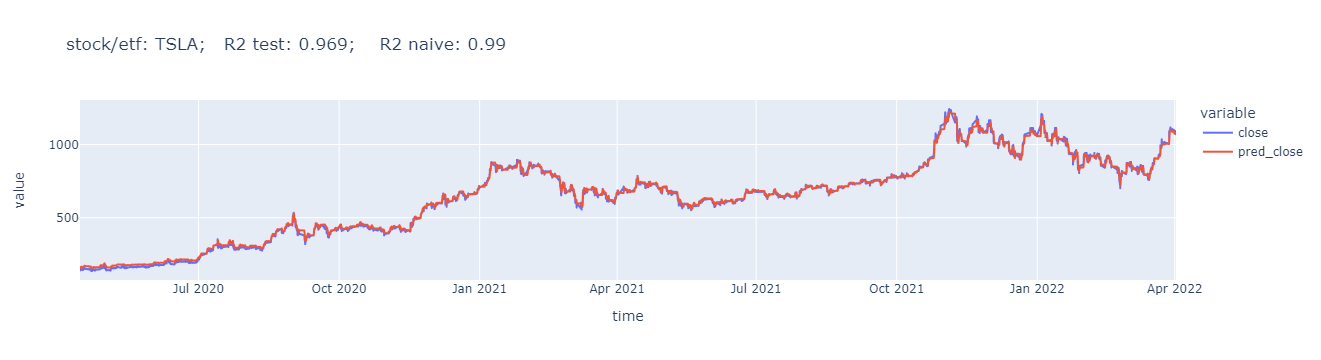

In [42]:
update_graph('TSLA', 60, 'LSTM')